# Naive Bayesian - Gaussian

In [1]:
import numpy as np
import matplotlib.pyplot as plt

<img style="background-color: white" src="../figures/normal.png" width="500">

$$
P(y|x) = \frac{P(x|y)P(y)}{P(x)}
$$

## Let's understand each part

### 1. Prior $P(y)$

In [2]:
X_train = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [9, 10, 11],
    [2, 4, 5]
])

y_train = np.array([0, 1, 1, 0])

X_test = np.array([
    [2, 3, 4],
    [7, 8, 9]
])

y_test = np.array([0, 1])

In [3]:
m0 = len(X_train[y_train==0])
m1 = len(X_train[y_train==1])
m0, m1

(2, 2)

In [4]:
prior0 = m0 / (m0 + m1)
prior1 = m1 / (m0 + m1)

prior0, prior1

(0.5, 0.5)

### 2. Likelihood / Conditional Probability $P(x|y)$

$$ P(x^i_j \in \text{test} \mid y=1 ; \mu_{1j}, \sigma_{1j}^{2}) = \frac{1}{\sqrt{2\pi\sigma_{1j}^{2}}}e ^{-\frac{(x^i_j-\mu_{1j})^{2}}{2\sigma_{1j}^{2}}}$$
$$ P(x^i_j \in \text{test} \mid y=0 ; \mu_{0j}, \sigma_{0j}^{2}) = \frac{1}{\sqrt{2\pi\sigma_{0j}^{2}}}e ^{-\frac{(x^i_j-\mu_{0j})^{2}}{2\sigma_{0j}^{2}}}$$

In [6]:
def mean_std(X, y, k):
    n = X.shape[1]
    mean = np.zeros((k, n))
    std  = np.zeros((k, n))
    for label in range(k):
        mean[label, :] = X[y==label].mean(axis=0)
        std[label, :]  = X[y==label].std(axis=0)
    return mean, std
        
mean, std = mean_std(X_train, y_train, k=2)

In [7]:
mean, std

(array([[1.5, 3. , 4. ],
        [6.5, 7.5, 8.5]]),
 array([[0.5, 1. , 1. ],
        [2.5, 2.5, 2.5]]))

In [8]:
def gaussian_pdf(X, mean, std):
    left = 1 / (np.sqrt(2 * np.pi) * std)
    e = (X - mean) ** 2 / (2 * (std ** 2))
    right = np.exp(-e)
    return left*right
    
px_y0 = gaussian_pdf(X_test, mean[0], std[0])
px_y1 = gaussian_pdf(X_test, mean[1], std[1])

In [10]:
np.set_printoptions(suppress=True)

In [12]:
X_test

array([[2, 3, 4],
       [7, 8, 9]])

In [14]:
px_y0
#0.483 = probability of first sample belonging to class 0, based on feature 1
#0.398 = probability of first sample belonging to class 0, based on feature 2

#0     = probability of second sample belonging to class 0, based on feature 1

array([[0.48394145, 0.39894228, 0.39894228],
       [0.        , 0.00000149, 0.00000149]])

$$P(x \mid y) = \prod_{j=1}^n P( x_j \mid y )$$

In [15]:
total_likelihood0 = np.prod(px_y0, axis=1)
total_likelihood1 = np.prod(px_y1, axis=1)

### 3. $P(y)P(x|y)$

In [18]:
posterior0 = prior0 * total_likelihood0
posterior1 = prior1 * total_likelihood1

In [20]:
posterior1

array([0.00001575, 0.00191347])

### 4. Predict

In [21]:
yhat = 1 * posterior1 > posterior0

yhat

array([False,  True])

## Let's implement

## 1. Prepare your data

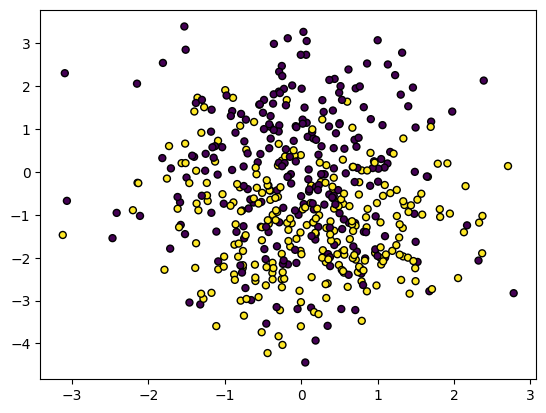

In [22]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# generate quite a lot of noise
# with only 4 informative features out of 10
# with 2 redundant features, overlapping with that 4 informative features
# and 4 noisy features
# Also, make std wider using n_clusters=2
X, y = make_classification(n_samples=500, n_features=10, n_redundant=2, n_informative=4,
                             n_clusters_per_class=2, random_state=14)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')

# look at the data...it is likely not linearly separable!

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# feature scaling helps improve reach convergence faster
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 2. Calculate the mean and std for each feature for each class

In [23]:
def mean_std(X_train, y_train):
    n = X_train.shape[1]
    mean = np.zeros((2, n))
    std = np.zeros((2, n))
    for label in [0, 1]:
        mean[label, :] = X_train[y_train==label].mean(axis=0)
        std[label, :]  = X_train[y_train==label].std(axis=0)
    return mean, std

mean, std = mean_std(X_train, y_train)
assert mean.shape == (2, X_train.shape[1])
assert std.shape == (2, X_train.shape[1])

## 3. Define the probability density function so we can later calculate $p(x_j \mid y)$

In [24]:
def gaussian_pdf(X, mean, std):
    left = 1 / (np.sqrt(2 * np.pi) * std)
    e = (X - mean) ** 2 / (2 * (std ** 2))
    right = np.exp(-e)
    return left*right

## 4. Calculate the likelihood by calculating the probability density $p(x_j \mid y)$

In [25]:
likelihood0 = gaussian_pdf(X_test, mean[0, :], std[0, :])
likelihood1 = gaussian_pdf(X_test, mean[1, :], std[0, :])

print(likelihood0.shape)

#pdf should have probability of each sample for each feature
assert likelihood0.shape == (X_test.shape[0], X_test.shape[1]), "Shape is wrong for pdf0!"
assert likelihood1.shape == (X_test.shape[0], X_test.shape[1]), "Shape is wrong for pdf1!"

(150, 10)


### 4.1 Calculate the total likelihood by calculating $p(x \mid y)$

In [26]:
# np.product
# P(feature1|class0) * P(feature2|class0)
total_likelihood0 = np.prod(likelihood0, axis=1)

# P(feature1|class1) * P(feature2|class1)
total_likelihood1 = np.prod(likelihood1, axis=1)

print(total_likelihood0.shape)

(150,)


### 4.2 Calculate the prior $p(y)$

In [27]:
# probability for class 0 and 1
m0 = len(X_train[y_train==0])
m1 = len(X_train[y_train==1])
prior0 = m0 / (m0 + m1)
prior1 = m1 / (m0 + m1)

assert prior0 + prior1 == 1, "probability not equal 1"

## 5. Calculate the posterior $p(x \mid y)p(y)$ for each class

In [28]:
# P(class0) * P(feature1|class0) * P(feature2|class0)
posterior0 = prior0 * total_likelihood0    
# P(class1) * P(feature1|class1) * P(feature2|class1)
posterior1 = prior1 * total_likelihood1

## 6. Calculate accuracy

In [29]:
#if probability of class 1 is more than 0, then True
yhat = 1 * posterior1 > posterior0
    
from sklearn.metrics import average_precision_score, classification_report
print("=========Average precision score=======")
print(average_precision_score(y_test, yhat))
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))

=========Average precision score=======
0.7739136904761904
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.69      0.93      0.79        70
           1       0.91      0.64      0.75        80

    accuracy                           0.77       150
   macro avg       0.80      0.78      0.77       150
weighted avg       0.81      0.77      0.77       150

